# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

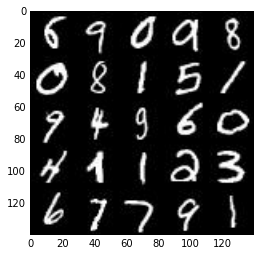

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

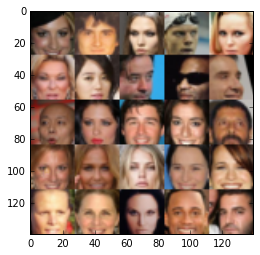

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    keep_prob = 0.8
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28xout_dim
        x1 = tf.layers.conv2d(images, 32, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        # relu1 = tf.maximum(alpha * x1, x1)
        relu1 = tf.nn.dropout(tf.maximum(alpha * x1, x1), keep_prob)
        # 14x14x32
        
        x2 = tf.layers.conv2d(relu1, 64, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        # relu2 = tf.maximum(alpha * bn2, bn2)
        relu2 = tf.nn.dropout(tf.maximum(alpha * bn2, bn2), keep_prob)
        # 7x7x64
        
        x3 = tf.layers.conv2d(relu2, 128, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        # relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.nn.dropout(tf.maximum(alpha * bn3, bn3), keep_prob)
        # 4x4x128

        x4 = tf.layers.conv2d(relu3, 256, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn4 = tf.layers.batch_normalization(x4, training=True)
        # relu4 = tf.maximum(alpha * bn4, bn4)
        relu4 = tf.nn.dropout(tf.maximum(alpha * bn4, bn4), keep_prob)
        # 2x2x256
        
        # Flatten it
        flat = tf.reshape(relu4, (-1, 2*2*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    keep_prob = 0.8
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        # x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(tf.maximum(alpha * x1, x1), keep_prob)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 3, strides=1, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.nn.dropout(tf.maximum(alpha * x2, x2), keep_prob)
        # 7x7x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 3, strides=2, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.nn.dropout(tf.maximum(alpha * x3, x3), keep_prob)
        # 14x14x64 now
        
        x4 = tf.layers.conv2d_transpose(x3, 32, 5, strides=1, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.nn.dropout(tf.maximum(alpha * x4, x4), keep_prob)
        # 14x14x32 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same',
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28xout_channel_dim now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Smoothing 
    smooth = 0.1
    d_loss_real = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                        labels=tf.ones_like(d_model_real) * (1-smooth)))
    d_loss_fake = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # extract parameters
    if data_image_mode == 'L':
        out_channel_dim = 1
    if data_image_mode == 'RGB':
        out_channel_dim = 3
    
    print_loss_every = 50
    print_image_every = 500
    n_images = 5 * 5
    
    # initialize the DCGAN net
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], out_channel_dim, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr: learning_rate})

                if steps % print_loss_every == 0:
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % print_image_every == 0:
                    show_generator_output(sess, n_images, input_z, out_channel_dim, data_image_mode)
        
        show_generator_output(sess, n_images, input_z, out_channel_dim, data_image_mode)
        
        saver.save(sess, './checkpoints/generator.ckpt')


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

[Errno 17] File exists: './checkpoints'
[INFO] Skip 'mkdir' process.
Epoch 1/2... Discriminator Loss: 1.5739... Generator Loss: 2.3401
Epoch 1/2... Discriminator Loss: 1.9201... Generator Loss: 0.2746
Epoch 1/2... Discriminator Loss: 2.1128... Generator Loss: 0.2691
Epoch 1/2... Discriminator Loss: 1.1829... Generator Loss: 1.0674
Epoch 1/2... Discriminator Loss: 0.8989... Generator Loss: 1.2801
Epoch 1/2... Discriminator Loss: 1.3399... Generator Loss: 0.9653
Epoch 1/2... Discriminator Loss: 0.9118... Generator Loss: 1.9959
Epoch 1/2... Discriminator Loss: 1.1724... Generator Loss: 0.7500
Epoch 1/2... Discriminator Loss: 1.0853... Generator Loss: 1.3852
Epoch 1/2... Discriminator Loss: 0.9980... Generator Loss: 0.9389


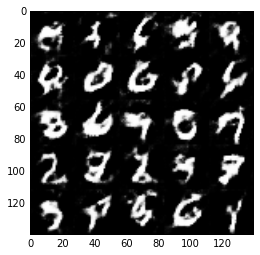

Epoch 1/2... Discriminator Loss: 1.0771... Generator Loss: 0.8560
Epoch 1/2... Discriminator Loss: 1.0746... Generator Loss: 0.9654
Epoch 1/2... Discriminator Loss: 1.1076... Generator Loss: 1.7211
Epoch 1/2... Discriminator Loss: 1.5209... Generator Loss: 2.7188
Epoch 1/2... Discriminator Loss: 1.0391... Generator Loss: 0.9643
Epoch 1/2... Discriminator Loss: 1.1114... Generator Loss: 3.1300
Epoch 1/2... Discriminator Loss: 0.8757... Generator Loss: 1.2423
Epoch 1/2... Discriminator Loss: 1.1565... Generator Loss: 1.0000
Epoch 2/2... Discriminator Loss: 0.8038... Generator Loss: 1.7723
Epoch 2/2... Discriminator Loss: 0.8943... Generator Loss: 1.7531


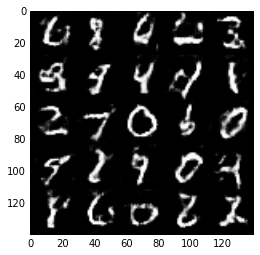

Epoch 2/2... Discriminator Loss: 0.8282... Generator Loss: 1.4622
Epoch 2/2... Discriminator Loss: 1.2581... Generator Loss: 2.3747
Epoch 2/2... Discriminator Loss: 0.8334... Generator Loss: 2.6953
Epoch 2/2... Discriminator Loss: 0.5159... Generator Loss: 2.0914
Epoch 2/2... Discriminator Loss: 0.8514... Generator Loss: 1.7685
Epoch 2/2... Discriminator Loss: 0.8261... Generator Loss: 2.0457
Epoch 2/2... Discriminator Loss: 0.9410... Generator Loss: 1.1472
Epoch 2/2... Discriminator Loss: 0.5225... Generator Loss: 1.9137
Epoch 2/2... Discriminator Loss: 0.7420... Generator Loss: 2.2089
Epoch 2/2... Discriminator Loss: 1.3111... Generator Loss: 0.6661


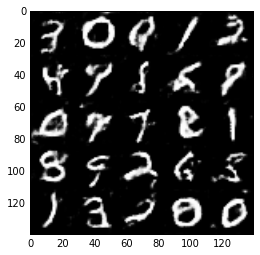

Epoch 2/2... Discriminator Loss: 0.6182... Generator Loss: 2.4927
Epoch 2/2... Discriminator Loss: 1.3305... Generator Loss: 0.8477
Epoch 2/2... Discriminator Loss: 1.0311... Generator Loss: 1.0134
Epoch 2/2... Discriminator Loss: 0.5027... Generator Loss: 1.2055
Epoch 2/2... Discriminator Loss: 0.7182... Generator Loss: 1.7490
Epoch 2/2... Discriminator Loss: 0.5272... Generator Loss: 2.0119
Epoch 2/2... Discriminator Loss: 0.8383... Generator Loss: 1.7520


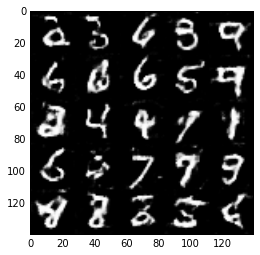

In [17]:
batch_size = 64
z_dim = 100
learning_rate = 0.0008
beta1 = 0.5

save_path = './checkpoints'
try:
    import os
    os.makedirs(save_path)
except OSError as e:
    print(e)
    print("[INFO] Skip 'mkdir' process.")

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

[Errno 17] File exists: './checkpoints'
[INFO] Skip 'mkdir' process.
Epoch 1/1... Discriminator Loss: 0.7668... Generator Loss: 1.9222
Epoch 1/1... Discriminator Loss: 0.7012... Generator Loss: 1.7857
Epoch 1/1... Discriminator Loss: 0.7671... Generator Loss: 1.8606
Epoch 1/1... Discriminator Loss: 0.9970... Generator Loss: 0.8513
Epoch 1/1... Discriminator Loss: 1.3139... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 1.0151... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 0.8239... Generator Loss: 2.0300
Epoch 1/1... Discriminator Loss: 1.2003... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 0.9622... Generator Loss: 1.2811


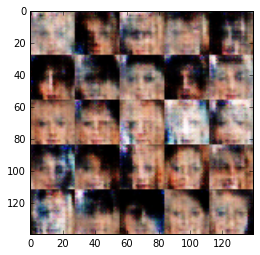

Epoch 1/1... Discriminator Loss: 1.6286... Generator Loss: 0.4256
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.5937
Epoch 1/1... Discriminator Loss: 1.0987... Generator Loss: 1.2240
Epoch 1/1... Discriminator Loss: 1.0601... Generator Loss: 1.3454
Epoch 1/1... Discriminator Loss: 1.0173... Generator Loss: 1.1384
Epoch 1/1... Discriminator Loss: 1.0858... Generator Loss: 0.8686
Epoch 1/1... Discriminator Loss: 1.1223... Generator Loss: 1.4015
Epoch 1/1... Discriminator Loss: 0.9818... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.9548... Generator Loss: 3.0713
Epoch 1/1... Discriminator Loss: 1.1383... Generator Loss: 0.9462


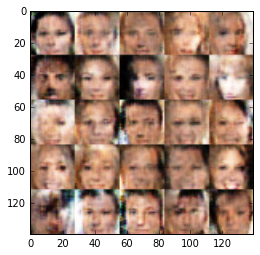

Epoch 1/1... Discriminator Loss: 0.9271... Generator Loss: 1.2014
Epoch 1/1... Discriminator Loss: 1.1579... Generator Loss: 1.8561
Epoch 1/1... Discriminator Loss: 1.0147... Generator Loss: 1.7638
Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 0.9420
Epoch 1/1... Discriminator Loss: 1.2958... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.5427
Epoch 1/1... Discriminator Loss: 1.0300... Generator Loss: 1.7010
Epoch 1/1... Discriminator Loss: 1.0969... Generator Loss: 1.0945
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 2.0414
Epoch 1/1... Discriminator Loss: 1.0911... Generator Loss: 1.1069


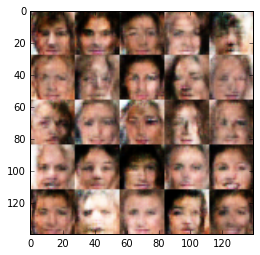

Epoch 1/1... Discriminator Loss: 1.2481... Generator Loss: 0.6548
Epoch 1/1... Discriminator Loss: 1.0499... Generator Loss: 1.4216
Epoch 1/1... Discriminator Loss: 1.1357... Generator Loss: 0.8345
Epoch 1/1... Discriminator Loss: 1.1503... Generator Loss: 1.4087
Epoch 1/1... Discriminator Loss: 1.2138... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 0.6847
Epoch 1/1... Discriminator Loss: 1.0900... Generator Loss: 1.2145
Epoch 1/1... Discriminator Loss: 1.1200... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.1558... Generator Loss: 0.5788
Epoch 1/1... Discriminator Loss: 0.8910... Generator Loss: 1.0974


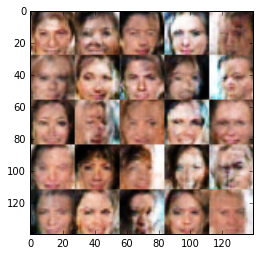

Epoch 1/1... Discriminator Loss: 0.9749... Generator Loss: 1.8847
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.5662
Epoch 1/1... Discriminator Loss: 0.9175... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 1.2474... Generator Loss: 1.0575
Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 0.9357
Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 1.3429... Generator Loss: 1.6444
Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 1.1868
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.7145
Epoch 1/1... Discriminator Loss: 0.9282... Generator Loss: 1.2713


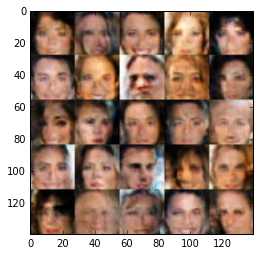

Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 1.2263... Generator Loss: 1.2754
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 0.8367
Epoch 1/1... Discriminator Loss: 1.5485... Generator Loss: 0.5466
Epoch 1/1... Discriminator Loss: 0.9016... Generator Loss: 1.1767
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.5734
Epoch 1/1... Discriminator Loss: 1.0064... Generator Loss: 0.6656
Epoch 1/1... Discriminator Loss: 1.0365... Generator Loss: 0.9560
Epoch 1/1... Discriminator Loss: 1.0580... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.5217... Generator Loss: 0.7132


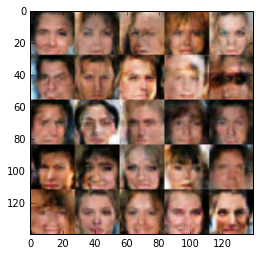

Epoch 1/1... Discriminator Loss: 1.1304... Generator Loss: 1.0613
Epoch 1/1... Discriminator Loss: 1.0674... Generator Loss: 0.8168
Epoch 1/1... Discriminator Loss: 0.9815... Generator Loss: 1.2559
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.8583
Epoch 1/1... Discriminator Loss: 1.1374... Generator Loss: 1.7587
Epoch 1/1... Discriminator Loss: 1.0535... Generator Loss: 1.0283
Epoch 1/1... Discriminator Loss: 1.2116... Generator Loss: 0.7595
Epoch 1/1... Discriminator Loss: 0.8808... Generator Loss: 1.5899
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 1.7899
Epoch 1/1... Discriminator Loss: 1.2786... Generator Loss: 0.5074


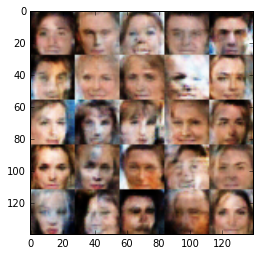

Epoch 1/1... Discriminator Loss: 0.9433... Generator Loss: 1.0437
Epoch 1/1... Discriminator Loss: 0.9394... Generator Loss: 1.1527
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.4536
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.0568... Generator Loss: 1.0058
Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 1.3815
Epoch 1/1... Discriminator Loss: 0.7630... Generator Loss: 1.1845
Epoch 1/1... Discriminator Loss: 1.1210... Generator Loss: 0.5259
Epoch 1/1... Discriminator Loss: 1.2923... Generator Loss: 1.0517
Epoch 1/1... Discriminator Loss: 1.0944... Generator Loss: 1.0347


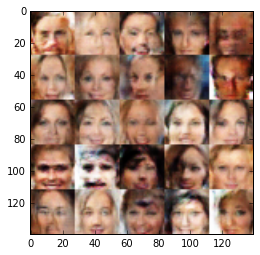

Epoch 1/1... Discriminator Loss: 0.9263... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 0.9665
Epoch 1/1... Discriminator Loss: 0.9840... Generator Loss: 1.3862
Epoch 1/1... Discriminator Loss: 0.8937... Generator Loss: 0.9794
Epoch 1/1... Discriminator Loss: 0.7764... Generator Loss: 1.6032
Epoch 1/1... Discriminator Loss: 1.0297... Generator Loss: 0.9328
Epoch 1/1... Discriminator Loss: 0.7640... Generator Loss: 1.7281
Epoch 1/1... Discriminator Loss: 1.0183... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 0.8833... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.2541... Generator Loss: 1.2059


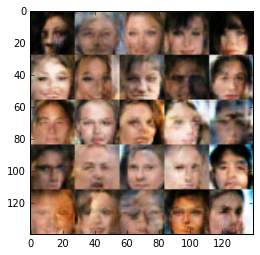

Epoch 1/1... Discriminator Loss: 0.9835... Generator Loss: 0.9253
Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 1.1852... Generator Loss: 1.0667
Epoch 1/1... Discriminator Loss: 0.9341... Generator Loss: 1.1275
Epoch 1/1... Discriminator Loss: 1.1050... Generator Loss: 0.4640
Epoch 1/1... Discriminator Loss: 1.1087... Generator Loss: 0.9127
Epoch 1/1... Discriminator Loss: 1.0413... Generator Loss: 0.7152
Epoch 1/1... Discriminator Loss: 0.8726... Generator Loss: 0.9195
Epoch 1/1... Discriminator Loss: 1.0214... Generator Loss: 0.9453
Epoch 1/1... Discriminator Loss: 0.9388... Generator Loss: 1.0198


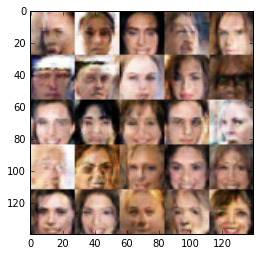

Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.1664... Generator Loss: 1.9435
Epoch 1/1... Discriminator Loss: 1.1383... Generator Loss: 0.9872
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 0.7254
Epoch 1/1... Discriminator Loss: 0.7433... Generator Loss: 1.4943
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 1.1898
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 0.8200
Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 0.7674
Epoch 1/1... Discriminator Loss: 0.8994... Generator Loss: 1.5712
Epoch 1/1... Discriminator Loss: 1.0763... Generator Loss: 1.3514


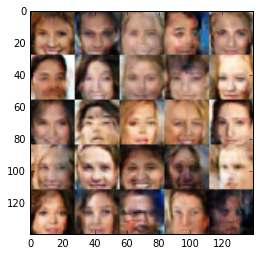

Epoch 1/1... Discriminator Loss: 1.0517... Generator Loss: 1.0937
Epoch 1/1... Discriminator Loss: 1.0198... Generator Loss: 1.5364
Epoch 1/1... Discriminator Loss: 0.7165... Generator Loss: 1.0258
Epoch 1/1... Discriminator Loss: 1.0630... Generator Loss: 0.9479
Epoch 1/1... Discriminator Loss: 0.9691... Generator Loss: 0.8977
Epoch 1/1... Discriminator Loss: 0.8406... Generator Loss: 1.1312
Epoch 1/1... Discriminator Loss: 1.0060... Generator Loss: 1.5330
Epoch 1/1... Discriminator Loss: 0.9011... Generator Loss: 1.6710
Epoch 1/1... Discriminator Loss: 1.1588... Generator Loss: 0.9850
Epoch 1/1... Discriminator Loss: 1.5551... Generator Loss: 3.6886


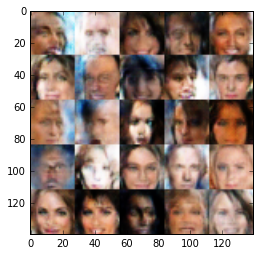

Epoch 1/1... Discriminator Loss: 0.6181... Generator Loss: 1.5085
Epoch 1/1... Discriminator Loss: 1.1476... Generator Loss: 1.0179
Epoch 1/1... Discriminator Loss: 0.9074... Generator Loss: 1.1630
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 0.4843
Epoch 1/1... Discriminator Loss: 0.8362... Generator Loss: 0.9946
Epoch 1/1... Discriminator Loss: 0.9553... Generator Loss: 1.9266


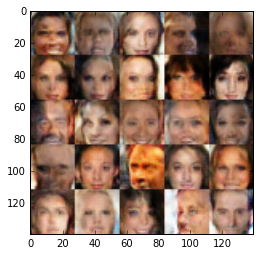

In [18]:
batch_size = 32
z_dim = 100
learning_rate = 0.0008
beta1 = 0.4

save_path = './checkpoints'
try:
    import os
    os.makedirs(save_path)
except OSError as e:
    print(e)
    print("[INFO] Skip 'mkdir' process.")
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.